# Grammatical Evolution of Differential Equations
### Symbolic Regression of Dynamical Systems using PonyGE2 - part 2

---

- **Author:** Michelangelo Pozza
- **Student ID:** IN2300012 
- **Course:** Global and Multiobjective Optimization

---

#### Main tasks:

- Take a physical system governed by a set of differential equations --> double pendulum
- Generate a collection of data from the system (using a
simulation) --> odeint
- Try to evolve the original equations with GP (notice: what
variables do you need? What operators?) --> we define a system of first order differential equation and we evolve both of them

## Dynamics and Simulation of a Damped Double Pendulum

Consider the double pendulum system consisting of two masses $m_1$ and $m_2$ connected by rigid rods of length $L_1$ and $L_2$, subject to damping coefficients $b_1$ and $b_2$.

<div align="center">
  <img src="img/double_pend.png" width="600" height="auto">
  <br>
  <em>Figure 1: Schematic of the damped double pendulum.</em>
</div>

### State Variables
For numerical simulation, we define the state vector $x$ to alternate between position and velocity for each joint:

$$x = \begin{bmatrix} x_1 \\ x_2 \\ x_3 \\ x_4 \end{bmatrix} = \begin{bmatrix} \theta_1 \\ \dot{\theta}_1 \\ \theta_2 \\ \dot{\theta}_2 \end{bmatrix}$$

Where:
* $x_1$: Angle of mass 1 ($\theta_1$)
* $x_2$: Angular velocity of mass 1 ($\dot{\theta}_1$)
* $x_3$: Angle of mass 2 ($\theta_2$)
* $x_4$: Angular velocity of mass 2 ($\dot{\theta}_2$)

### State-Space Representation

The system of first-order differential equations $\dot{x} = f(x, t)$ is defined as:

$$
\begin{bmatrix} \dot{x}_1 \\ \dot{x}_2 \\ \dot{x}_3 \\ \dot{x}_4 \end{bmatrix} = \begin{bmatrix} x_2 \\ a_1 \\ x_4 \\ a_2 \end{bmatrix}
$$

Where $a_1$ and $a_2$ correspond to the angular accelerations $\ddot{\theta}_1$ and $\ddot{\theta}_2$.

#### 1. Matrix Form (for computing accelerations)

The accelerations $a_1$ and $a_2$ are obtained by solving the linear system $M \mathbf{a} = F$ at each time step:

$$
\underbrace{\begin{bmatrix}
(m_1 + m_2) L_1 & m_2 L_2 \cos(x_1 - x_3) \\
L_1 \cos(x_1 - x_3) & L_2
\end{bmatrix}}_{M}
\begin{bmatrix} a_1 \\ a_2 \end{bmatrix} =
\underbrace{\begin{bmatrix}
-m_2 L_2 x_4^2 \sin(x_1 - x_3) - g(m_1 + m_2) \sin(x_1) - b_1 x_2 \\
L_1 x_2^2 \sin(x_1 - x_3) - g \sin(x_3) - \frac{b_2}{m_2} x_4
\end{bmatrix}}_{F}
$$

#### 2. Explicit Form

By solving the matrix system (inverting $M$), we obtain the explicit equations for the state derivatives. First, we define the determinant $\Delta$ and the force terms $F_1, F_2$ (the components of vector $F$ above):

$$\Delta = L_1 L_2 [m_1 + m_2 \sin^2(x_1 - x_3)]$$

The complete equations of motion are:

$$
\begin{aligned}
\dot{x}_1 &= x_2 \\
\dot{x}_2 &= \frac{L_2 F_1 - m_2 L_2 \cos(x_1 - x_3) F_2}{L_1 L_2 (m_1 + m_2) - m_2 L_1 L_2 \cos^2(x_1 - x_3)} \\
\dot{x}_3 &= x_4 \\
\dot{x}_4 &= \frac{(m_1 + m_2) L_1 F_2 - L_1 \cos(x_1 - x_3) F_1}{L_1 L_2 (m_1 + m_2) - m_2 L_1 L_2 \cos^2(x_1 - x_3)}
\end{aligned}
$$

Where the terms $F_1$ and $F_2$ are:

* $F_1 = -m_2 L_2 x_4^2 \sin(x_1 - x_3) - g(m_1 + m_2) \sin(x_1) - b_1 x_2$
* $F_2 = L_1 x_2^2 \sin(x_1 - x_3) - g \sin(x_3) - \frac{b_2}{m_2} x_4$

In [7]:
# Executed in Python 3.10.12

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error as mse

In [8]:
def physics(x, t, l1, l2, m1, m2, b1, b2, g):
    
    theta1, theta1_dot, theta2, theta2_dot = x
    
    denominator = l1*l2*(m1+m2)-m2*l1*l2*np.cos(theta1-theta2)**2
    
    F1 = -m2*l2*(theta2_dot**2)*np.sin(theta1-theta2)-g*(m1+m2)*np.sin(theta1)-b1*theta1_dot
    F2 = l1*(theta1_dot**2)*np.sin(theta1-theta2)-g*np.sin(theta2)-b2/m2*theta2_dot
    
    num1 = l2*F1-m2*l2*np.cos(theta1-theta2)*F2
    
    theta1_ddot = num1/denominator
    
    num2 = (m1+m2)*l1*F2-l1*np.cos(theta1-theta2)*F1
    
    theta2_ddot = num2/denominator
    
    return [theta1_dot, theta1_ddot, theta2_dot, theta2_ddot]

In [9]:
L1 = 1.0
L2 = 1.0
m1 = 1.0
m2 = 1.0
b1=0.1
b2=0.1
g = 9.8

# initial conditions
y0 = [np.pi/2, 0, np.pi/4, 0]

# simulation time
T = 2

# number of points
N = 100

# simulation time
t_sim = np.linspace(0, T, N)

# integration
sol = odeint(physics, y0, t_sim, args=(L1, L2, m1, m2, b1, b2, g))

# solution calculate in N rows and 4 columns (N,4)
solution_data = sol

# solution time (N,1)
solution_time = np.array(t_sim).reshape(N,1)

full_data = np.hstack((solution_time, solution_data))

column_names = ['t', 'x[0]', 'x[1]', 'x[2]', 'x[3]']
save_data = pd.DataFrame(full_data, columns=column_names)
save_data.to_csv('../datasets/double_pendulum.csv', index=False, header=True)

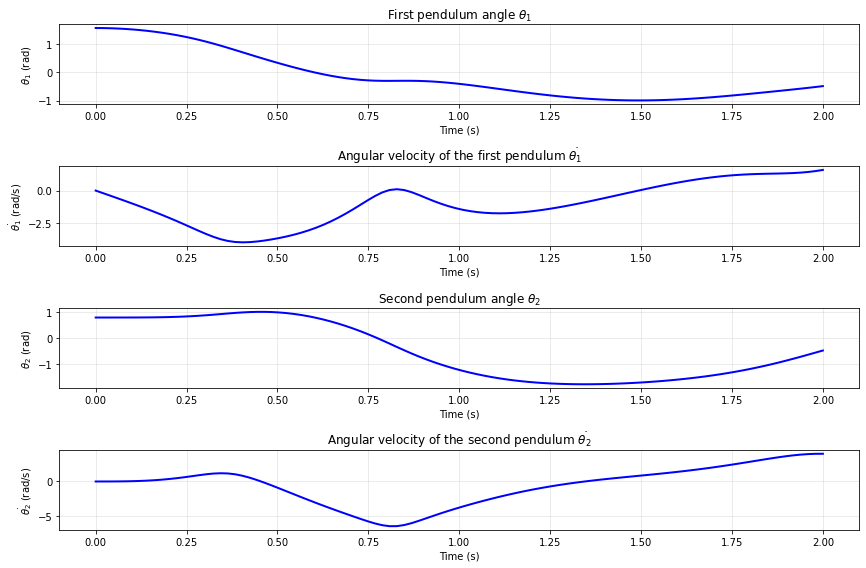

In [10]:
# Let's plot the angle theta and the angular velocity theta_dot    
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))
    
# Plot theta1
ax1.plot(full_data[:,0], full_data[:,1], 'b-', linewidth=2)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel(r'$\theta_1$ (rad)')
ax1.set_title(r'First pendulum angle $\theta_1$')
ax1.grid(True, alpha=0.3)

# Plot theta1_dot
ax2.plot(full_data[:,0], full_data[:,2], 'b-', linewidth=2)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel(r'$\dot{\theta_1}$ (rad/s)')
ax2.set_title(r'Angular velocity of the first pendulum $\dot{\theta_1}$')
ax2.grid(True, alpha=0.3)

# Plot theta2
ax3.plot(full_data[:,0], full_data[:,3], 'b-', linewidth=2)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel(r'$\theta_2$ (rad)')
ax3.set_title(r'Second pendulum angle $\theta_2$')
ax3.grid(True, alpha=0.3)

# Plot theta_dot2
ax4.plot(full_data[:,0], full_data[:,4], 'b-', linewidth=2)
ax4.set_xlabel('Time (s)')
ax4.set_ylabel(r'$\dot{\theta_2}$ (rad/s)')
ax4.set_title(r'Angular velocity of the second pendulum $\dot{\theta_2}$')
ax4.grid(True, alpha=0.3)
    
plt.tight_layout()

In [21]:
!python3 ponyge.py --parameters double_pendulum_params.txt


Start:	 2025-12-11 15:10:29.065630 

         Unit productions consume GE codons.
         Unit productions consume GE codons.
         Unit productions consume GE codons.
         Unit productions consume GE codons.
/home/michelangelo/Documents/Projext/Projext/PonyGE2/src/fitness/ff_double_pendulum.py:73: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(system, self.y0, self.t_eval, full_output=0)
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1553087451823D+01   r2 =  0.9706142009487D-16
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.0000000000000D+00   r2 =  0.9326397645832D-11
/home/michelangelo/Documents/Projext/Projext/Po

In [22]:
# this code for extracting the phenotype from the last created folder was partially 
# generated with Gemini Pro

base_path = "../results"

# take the last modified folder
paths = [os.path.join(base_path, d) for d in os.listdir(base_path)]
latest_folder = max([d for d in paths if os.path.isdir(d)], key=os.path.getmtime)

# find the last generation
files = [f for f in os.listdir(latest_folder) if f.endswith('.txt') and f[:-4].isdigit()]
last_file = max(files, key=lambda f: int(f[:-4]))

# read the content
with open(os.path.join(latest_folder, last_file), 'r') as f:
    content = f.read()

phenotype = re.search(r'Phenotype:\n(.+?)\n\nGenotype:', content, re.DOTALL).group(1).strip()
fitness = re.search(r'Fitness:\n(.+?)$', content, re.MULTILINE).group(1).strip()
equations = phenotype.split(';')

print(f"The best phenotype was: {phenotype} with fitness value={fitness}")
print(f"\nSo, the system of equations evolved is:\n--> x[0]'={equations[0]}\n--> x[1]'={equations[1]}\n--> x[2]'={equations[2]}\n--> x[3]'={equations[3]}")

The best phenotype was: x[1];9.8 / 3.50-x[0] * 9.8;x[3];2.0 / 1.04 / x[2]+x[2] / 1.0-(x[1])-9.8 / 2.16 / 9.8 / np.sin(x[0])*np.cos((x[0]-x[2])) * x[2] * np.cos(x[0]) * 9.8 / np.cos(x[3])+(x[3]-x[3]) * np.sin((x[0]-x[2])) with fitness value=1.8533678396199147

So, the system of equations evolved is:
--> x[0]'=x[1]
--> x[1]'=9.8 / 3.50-x[0] * 9.8
--> x[2]'=x[3]
--> x[3]'=2.0 / 1.04 / x[2]+x[2] / 1.0-(x[1])-9.8 / 2.16 / 9.8 / np.sin(x[0])*np.cos((x[0]-x[2])) * x[2] * np.cos(x[0]) * 9.8 / np.cos(x[3])+(x[3]-x[3]) * np.sin((x[0]-x[2]))


In [23]:
def system(x, t):
    
    theta1_dot = eval(equations[0])
    theta1_ddot = eval(equations[1])
    theta2_dot = eval(equations[2])
    theta2_ddot = eval(equations[3])
    
    return [theta1_dot, theta1_ddot, theta2_dot, theta2_ddot]

sol = odeint(system, y0, t_sim)

# solution calculate in N rows and 4 columns (N,4)
solution_data2 = sol

# solution time (N,1)
solution_time2 = np.array(t_sim).reshape(N,1)

full_data2 = np.hstack((solution_time2, solution_data2))

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5699960176184D+00   r2 =  0.5413570249640D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5699960176184D+00   r2 =  0.1353392562410D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5699960176184D+00   r2 =  0.1353392562410D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5699960176184D+00   r2 =  0.3383481406025D-17
 lsoda--  warning..internal t (=r1) 

/tmp/ipykernel_8872/2304075670.py:10: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(system, y0, t_sim)


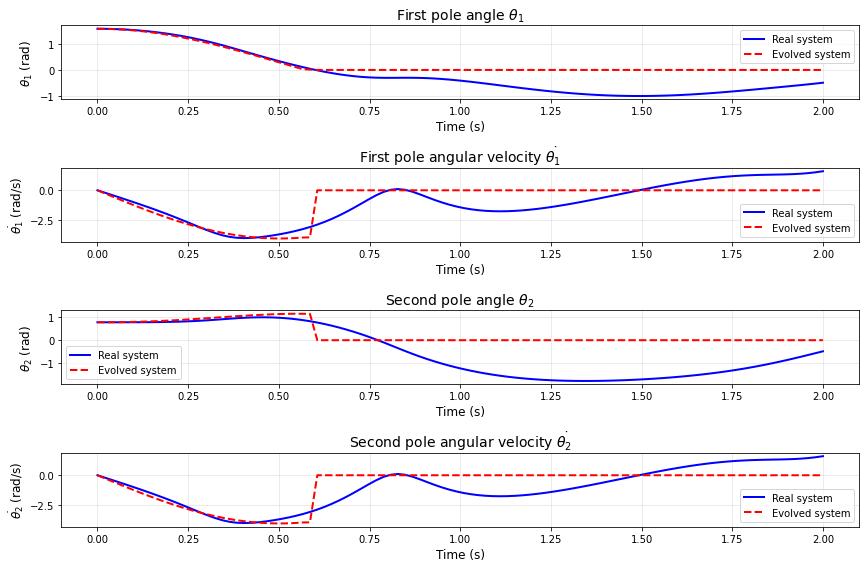

In [24]:
# Let's plot the angle theta and the angular velocity theta_dot    
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))
    
# Plot theta1
ax1.plot(full_data[:,0], full_data[:,1], 'b-', label='Real system', linewidth=2)
ax1.plot(full_data2[:,0], full_data2[:,1], 'r', linestyle='dashed', label='Evolved system', linewidth=2)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel(r'$\theta_1$ (rad)', fontsize=12)
ax1.set_title(r'First pole angle $\theta_1$', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot theta1_dot
ax2.plot(full_data[:,0], full_data[:,2], 'b-', label='Real system', linewidth=2)
ax2.plot(full_data2[:,0], full_data2[:,2], 'r', linestyle='dashed', label='Evolved system', linewidth=2)
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel(r'$\dot{\theta_1}$ (rad/s)', fontsize=12)
ax2.set_title(r'First pole angular velocity $\dot{\theta_1}$', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot theta2
ax3.plot(full_data[:,0], full_data[:,3], 'b-', label='Real system', linewidth=2)
ax3.plot(full_data2[:,0], full_data2[:,3], 'r', linestyle='dashed', label='Evolved system', linewidth=2)
ax3.set_xlabel('Time (s)', fontsize=12)
ax3.set_ylabel(r'$\theta_2$ (rad)', fontsize=12)
ax3.set_title(r'Second pole angle $\theta_2$', fontsize=14)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot theta2_dot
ax4.plot(full_data[:,0], full_data[:,2], 'b-', label='Real system', linewidth=2)
ax4.plot(full_data2[:,0], full_data2[:,2], 'r', linestyle='dashed', label='Evolved system', linewidth=2)
ax4.set_xlabel('Time (s)', fontsize=12)
ax4.set_ylabel(r'$\dot{\theta_2}$ (rad/s)', fontsize=12)
ax4.set_title(r'Second pole angular velocity $\dot{\theta_2}$', fontsize=14)
ax4.legend()
ax4.grid(True, alpha=0.3)
    
plt.tight_layout()

The mean square error on the first angle is: 0.33742602746432643
The mean square error on the first angular velocity is: 1.1343699554024653
The mean square error on the second angle is: 1.2018092492387606
The mean square error on the second angular velocity is: 7.965254774867572


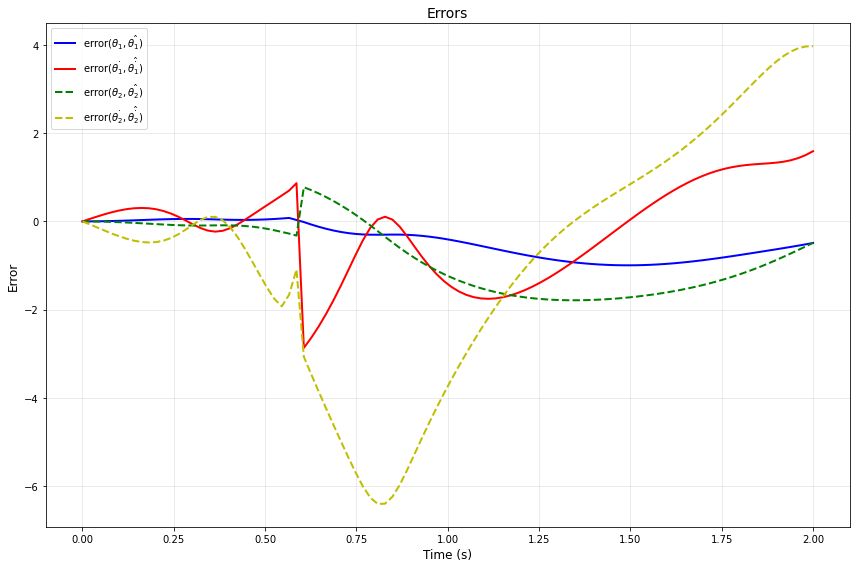

In [25]:
error_theta1 = full_data[:,1] - full_data2[:,1]
error_theta1_dot = full_data[:,2] - full_data2[:,2]
error_theta2 = full_data[:,3] - full_data2[:,3]
error_theta2_dot = full_data[:,4] - full_data2[:,4]

print("The mean square error on the first angle is: " + str(mse(full_data[:,1],full_data2[:,1])))
print("The mean square error on the first angular velocity is: " + str(mse(full_data[:,2],full_data2[:,2])))
print("The mean square error on the second angle is: " + str(mse(full_data[:,3],full_data2[:,3])))
print("The mean square error on the second angular velocity is: " + str(mse(full_data[:,4],full_data2[:,4])))

# Plot Errors
plt.figure(figsize=(12, 8))

plt.plot(full_data2[:,0], error_theta1, 'b-', label=r'error($\theta_1, \hat{\theta_1}$)', linewidth=2)
plt.plot(full_data2[:,0], error_theta1_dot, 'r-', label=r'error($\dot{\theta_1}, \hat{\dot{\theta_1}}$)', linewidth=2)
plt.plot(full_data2[:,0], error_theta2, 'g', linestyle='dashed', label=r'error($\theta_2, \hat{\theta_2}$)', linewidth=2)
plt.plot(full_data2[:,0], error_theta2_dot, 'y', linestyle='dashed', label=r'error($\dot{\theta_2}, \hat{\dot{\theta_2}}$)', linewidth=2)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel(r'Error', fontsize=12)
plt.title(r'Errors', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()